## **Example: CSTR Tank without Recycle**

### **Part 1: Dynamic Simulation**

**Step 0: import packages**


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

**Step 1: define parameters**

In [2]:
F0 = 1.0     # moles/time
F1 = 2.7     # moles/time
F3 = 1.8     # moles/time
F5 = 1.7     # moles/time
Xi_A0 = 0.95 # moles fraction
tau = 1/2.7  # time
k0 = 2.7     #  1/time
X1_A0 = 2/3  # moles fraction
X2_A0 = 1/3  # moles fraction
X3_A0 = 1/2  # moles fraction
X5_A0 = 1/2  # moles fraction

**Step 2: define each state variable**

In [3]:
def Xi_A(t):
  if t <= 2:
    return Xi_A0
  else:
    return Xi_A0 + 0.01

def X5_A(t):
  return X5_A0

def X1_A(t):
  return (F0*Xi_A(t) + F5*X5_A(t))/(F1)

def deriv_sivp(t,X2_A):
  return 1/tau * (X1_A(t) - X2_A) - k0*X2_A     # this one will be solved by solve_ivp

def deriv_odeint(X2_A,t):
  return 1/tau * (X1_A(t) - X2_A) - k0*X2_A     # this one will be solved by odeint

def X3_A(t, X2_A):
  if t == 0:
    return X3_A0
  else:
    return F1*X2_A/F3

**Step 3: integrate differential equations**

In [4]:
t = np.linspace(0, 5, 1000)
IC = [X2_A0]
X2_odeint = odeint(deriv_odeint,IC, t)
soln = solve_ivp(deriv_sivp, (t[0], t[-1]), IC, t_eval=t)
X2_sivp = soln.y

**Step 4: plot**

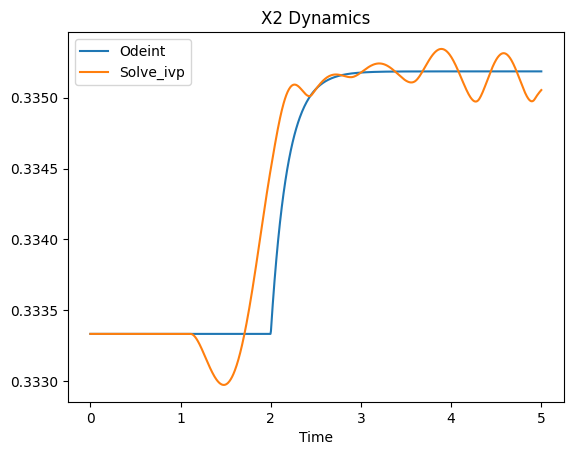

In [5]:
plt.plot(t,X2_odeint, t,X2_sivp[0])   # Think: why X2_sivp[0]? Why not just X2_sivp?
plt.title('X2 Dynamics')
plt.xlabel('Time')
plt.legend(['Odeint', 'Solve_ivp']);

odeint and solve_ivp are both functions in Python used for solving ordinary differential equations (ODEs), but they have some differences in terms of usage, algorithms, and input parameters. The differences in their implementations may lead to slightly different results, although they should generally provide similar solutions when used appropriately.

Algorithmic Differences:

odeint uses the LSODA (Livermore Solver for Ordinary Differential Equations) algorithm, which is a combination of Adams and BDF (Backward Differentiation Formula) methods.
solve_ivp provides multiple solvers, including LSODA, RK45 (Runge-Kutta), RK23, DOP853, etc. The default solver is the RK45 solver.

There's a really great explanation here if you're interested: [Differential Equations with odeint or solve_ivp](https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/)

**Calculate and plot other variables, using odeint solutoin**

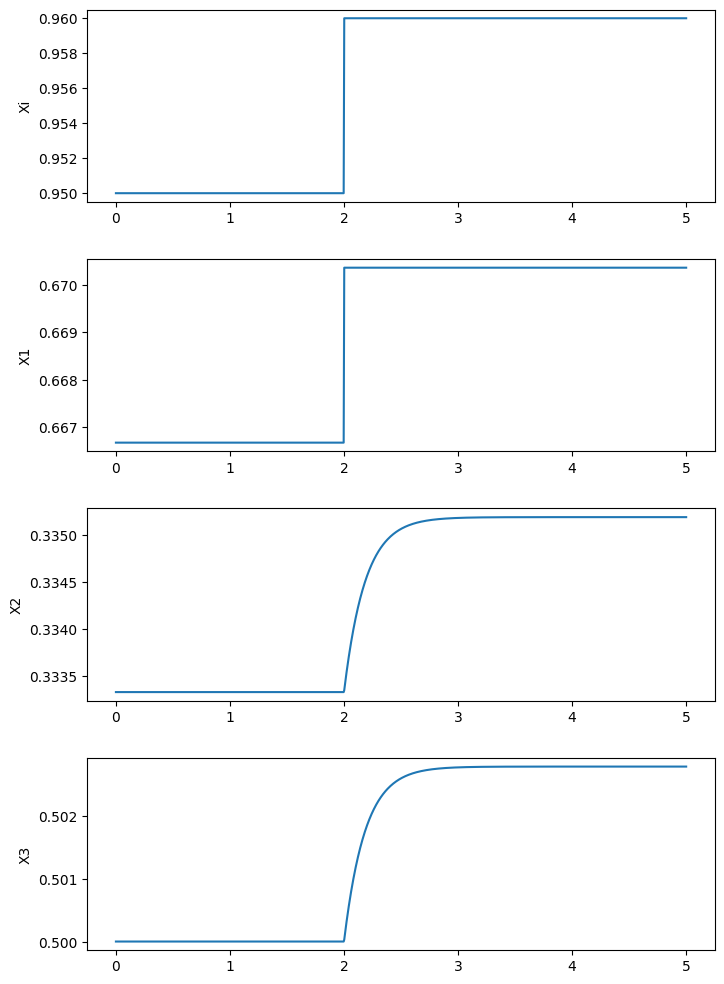

In [6]:
Xi_A_values = np.zeros(len(t))
X1_A_values = np.zeros(len(t))
X3_A_values = np.zeros(len(t))

for i in range(0, len(t)):
  Xi_A_values[i] = Xi_A(t[i])
  X1_A_values[i] = X1_A(t[i])
  X3_A_values[i] = X3_A(t[i], X2_odeint[i])


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_size_inches(7, 10)   # Set figure size to make it more beautiful
fig.tight_layout(h_pad = 2)

ax1.plot(t, Xi_A_values);
ax1.set_ylabel('Xi')

ax2.plot(t, X1_A_values);
ax2.set_ylabel('X1')

ax3.plot(t, X2_odeint);
ax3.set_ylabel('X2')

ax4.plot(t, X3_A_values);
ax4.set_ylabel('X3');

### **Part 2: Fit Transfer Function to X3 Response**

**Step 0: install and import packages**

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Assume the manipulated process input, $u$, and measured process output, $y$, are initially at steady-state $u_0,y_0$.

The response of a linear first-order system without time-delay can be written as a differential equation
$$\tau \frac{d(y-y_0)}{dt}+(y-y_0)=K(u-u_0)$$

or
$$\tau \frac{dy}{dt}+(y-y_0)=K(u-u_0)$$

At time $t_0$, the input $u$ is changed to a new constant value $u_{∞}$. Provided the system is stable (i.e, $\tau \geq 0$), the new steady state value of $y$ will be
$$y_{\infty}=y_0+K(u_{\infty}-u_0)$$

The solution to the differential equation can then be written as
$$y(t) = y_0 + K(u_{\infty}-u_0)(1-e^{-(t-t_0)/\tau})$$

**Step 1: create a function to compute the unit step change response of a first order system**



This fuction returns the response of a first order system to a unit change in input at $t=0$.

In [8]:
def FOS(t, K, tau):
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-t/tau)) for t in t])

**Step 2: shift and scale the experimental data to correspond to a unit step input at time $t=0$**

This generally involves three steps:

*   Set $t=0$ to where the unit step change took place.
*   Shift the response so $y = 0$ is the initial steady state
*   Rescale the response to a unit change in input
$$y_s = \frac{y(t)-y_0}{u_{\infty}-u_0}$$



In [9]:
X3_shifted = X3_A_values[399:-1]   # remember when we introduced the step change
X3_scaled = (X3_shifted-X3_A_values[0])/(0.01)  # remember the step change size is 0.01
t_shifted = t[399:-1] - t[399]

**Step 3: Create a function to measure the error between our FOS model and our measured X3 data.**

We seek to minimize the absolute error between our model $\hat{y_s}$ and our measured X3 data $y_s$.

error = $\int_0^T |\hat{y_s}-y_s|dt$

In [10]:
def err(guess, t, measured):
    K,tau = guess
    model = FOS(t,K,tau)
    error = sum(abs(model-measured))*(max(t)-min(t))/len(t)
    return error

**Step 4: Use scipy.optimize.minimize() to find the best fitting FOS parameters.**

K = 0.27778
tau = 0.19


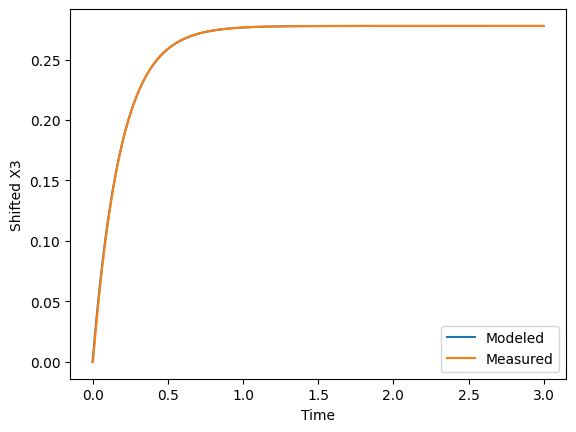

In [14]:
guess = [0.1, 0.1]   # What if you start with another guess, say, [10, 10]?
K,tau = minimize(err,guess,args=(t_shifted,X3_scaled)).x

print("K = {:.5f}".format(K))
print("tau = {:.2f}".format(tau))  # Compare with theoretical value

X3_modeled = FOS(t_shifted, K, tau)
plt.plot(t_shifted, X3_modeled, t_shifted, X3_scaled)  # Two lines completely overlaped
plt.legend(['Modeled','Measured']);
plt.ylabel('Shifted X3')
plt.xlabel('Time');